<a href="https://colab.research.google.com/github/rzqmhb/machine-learning-ti3f/blob/main/Minggu%2010%20-%20Recurrent%20Neural%20Network%20(RNN)/10_Roziq%20Mahbubi_RNN/RNN_praktikum1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Praktikum 1

### Setup

In [ ]:
import numpy as np # import np
import tensorflow_datasets as tfds # import dataset tensorflow
import tensorflow as tf # import tensorflow

tfds.disable_progress_bar() # disable progress bar milik dataset

In [ ]:
import matplotlib.pyplot as plt # import pyplot


def plot_graphs(history, metric): # function untuk visualisasi hasil training
 plt.plot(history.history[metric]) # plot data training
 plt.plot(history.history['val_'+metric], '') # plot data validasi
 plt.xlabel("Epochs")
 plt.ylabel(metric)
 plt.legend([metric, 'val_'+metric])

### Setup Input Pipeline

In [ ]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True) # Memuat dataset 'imdb_reviews' dan infonya
train_dataset, test_dataset = dataset['train'], dataset['test'] #  Membagi dataset menjadi data train dan test

train_dataset.element_spec # Mencetak spesifikasi data train

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
# mencetak sample data dari dataset
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [ ]:
# Menyiapkan dataset untuk pelatihan dengan teknik batching dan shuffling
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# mencetak sample data dari dataset
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])


texts:  [b'In my book "Basic Instinct" was a perfect film. It had outstanding acting on the parts of Stone, Douglas and all the supporting actors to the tiniest role. It had marvelous photography, music and the noirest noir script ever. All of it adding up to a film that is as good as it will ever get!<br /><br />This sequel is the exact opposite, it cannot possibly get worse, bad acting and a lame script, combined with totally inept direction, this is really bad, boring, annoying. The only thing that somewhat keeps you concentrated is the relatively short wait for the next scene that is an exact re-enacted copy of the original. These copies are so bad they make you laugh and I laughed a lot in spite of myself, because it was like watching the demolishing of a shining monument. The only thing that is good in this horrible mess are the excerpts of the Jerry Goldsmith score of BI1. Michael Caton-Jones and the half-wit responsible for the script even included the "There is no smoking in t

### Buat Teks Encoder

In [ ]:
# Membuat encoder untuk vektorisasi teks
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
# Mendapatkan vocab dari encoder
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [ ]:
# Melakukan encoding pada beberapa contoh
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[  8,  56, 271, ...,   0,   0,   0],
       [ 10, 103,  10, ...,   0,   0,   0],
       [ 30,  75,   4, ...,   0,   0,   0]])

In [ ]:
# mencetak sample data dari dataset setelah encoding
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'In my book "Basic Instinct" was a perfect film. It had outstanding acting on the parts of Stone, Douglas and all the supporting actors to the tiniest role. It had marvelous photography, music and the noirest noir script ever. All of it adding up to a film that is as good as it will ever get!<br /><br />This sequel is the exact opposite, it cannot possibly get worse, bad acting and a lame script, combined with totally inept direction, this is really bad, boring, annoying. The only thing that somewhat keeps you concentrated is the relatively short wait for the next scene that is an exact re-enacted copy of the original. These copies are so bad they make you laugh and I laughed a lot in spite of myself, because it was like watching the demolishing of a shining monument. The only thing that is good in this horrible mess are the excerpts of the Jerry Goldsmith score of BI1. Michael Caton-Jones and the half-wit responsible for the script even included the "There is no smoking in

### Buat Model

In [ ]:
# Membuat model Sequential dengan beberapa lapisan, termasuk Embedding dan LSTM
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 10s 10s/step
[-0.01021891]


In [ ]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 60ms/step
[-0.01021891]


In [ ]:
# Melakukan compile model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

###Train Model

In [ ]:
# Melakukan pelatihan model
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 59s 114ms/step - loss: 0.6768 - accuracy: 0.5368 - val_loss: 0.5961 - val_accuracy: 0.6776
Epoch 2/10
391/391 [==============================] - 35s 88ms/step - loss: 0.5108 - accuracy: 0.7435 - val_loss: 0.4260 - val_accuracy: 0.7964
Epoch 3/10
391/391 [==============================] - 25s 63ms/step - loss: 0.3784 - accuracy: 0.8288 - val_loss: 0.3646 - val_accuracy: 0.8333
Epoch 4/10
391/391 [==============================] - 25s 63ms/step - loss: 0.3396 - accuracy: 0.8488 - val_loss: 0.3435 - val_accuracy: 0.8458
Epoch 5/10
391/391 [==============================] - 24s 61ms/step - loss: 0.3231 - accuracy: 0.8597 - val_loss: 0.3408 - val_accuracy: 0.8557
Epoch 6/10
391/391 [==============================] - 24s 62ms/step - loss: 0.3135 - accuracy: 0.8645 - val_loss: 0.3412 - val_accuracy: 0.8547
Epoch 7/10
391/391 [==============================] - 24s 61ms/step - loss: 0.3084 - accuracy: 0.8659 - val_loss: 0.3289 - val_accuracy

In [ ]:
# Mengevaluasi model
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 11s 29ms/step - loss: 0.3382 - accuracy: 0.8606
Test Loss: 0.33820557594299316
Test Accuracy: 0.8606399893760681


(0.0, 0.6957005470991134)

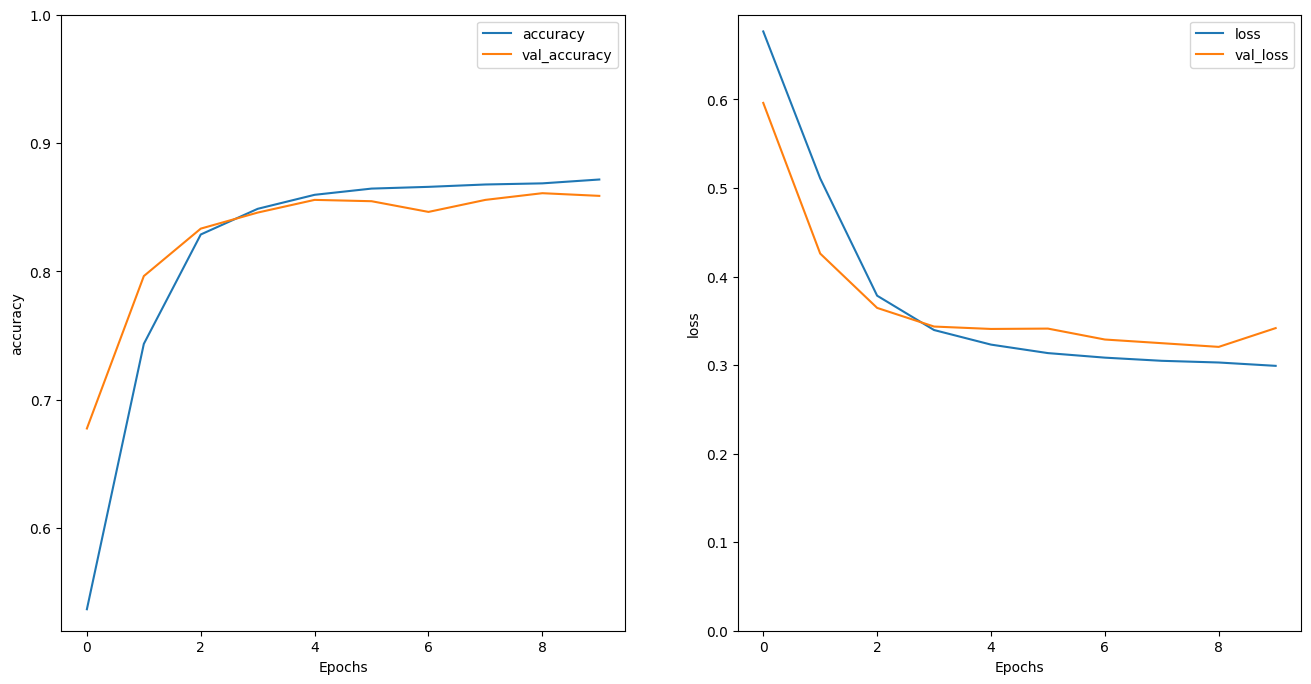

In [ ]:
# visualisasi hasil training
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [ ]:
# Membuat prediksi dengan model
sample_text = ('The movie was cool. The animation and the graphics '
                'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 2s 2s/step


###Stack two or more LSTM layers

In [ ]:
# Membuat dan melatih model kedua dengan arsitektur yang sedikit berbeda
model = tf.keras.Sequential([
        encoder,
        tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1)
      ])

In [ ]:
# compile model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
# pelatihan model
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 78s 151ms/step - loss: 0.6258 - accuracy: 0.5854 - val_loss: 0.4480 - val_accuracy: 0.7880
Epoch 2/10
391/391 [==============================] - 48s 122ms/step - loss: 0.3934 - accuracy: 0.8267 - val_loss: 0.3548 - val_accuracy: 0.8484
Epoch 3/10
391/391 [==============================] - 46s 117ms/step - loss: 0.3457 - accuracy: 0.8518 - val_loss: 0.3321 - val_accuracy: 0.8521
Epoch 4/10
391/391 [==============================] - 46s 118ms/step - loss: 0.3252 - accuracy: 0.8615 - val_loss: 0.3255 - val_accuracy: 0.8495
Epoch 5/10
391/391 [==============================] - 50s 127ms/step - loss: 0.3120 - accuracy: 0.8668 - val_loss: 0.3207 - val_accuracy: 0.8573
Epoch 6/10
391/391 [==============================] - 50s 127ms/step - loss: 0.3098 - accuracy: 0.8684 - val_loss: 0.3181 - val_accuracy: 0.8604
Epoch 7/10
391/391 [==============================] - 49s 124ms/step - loss: 0.3073 - accuracy: 0.8688 - val_loss: 0.3165 - val_ac

In [ ]:
# evaluasi hasil train
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 19s 48ms/step - loss: 0.3192 - accuracy: 0.8594
Test Loss: 0.31915202736854553
Test Accuracy: 0.8593999743461609


In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
                'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 7s 7s/step
[[-1.8272388]]


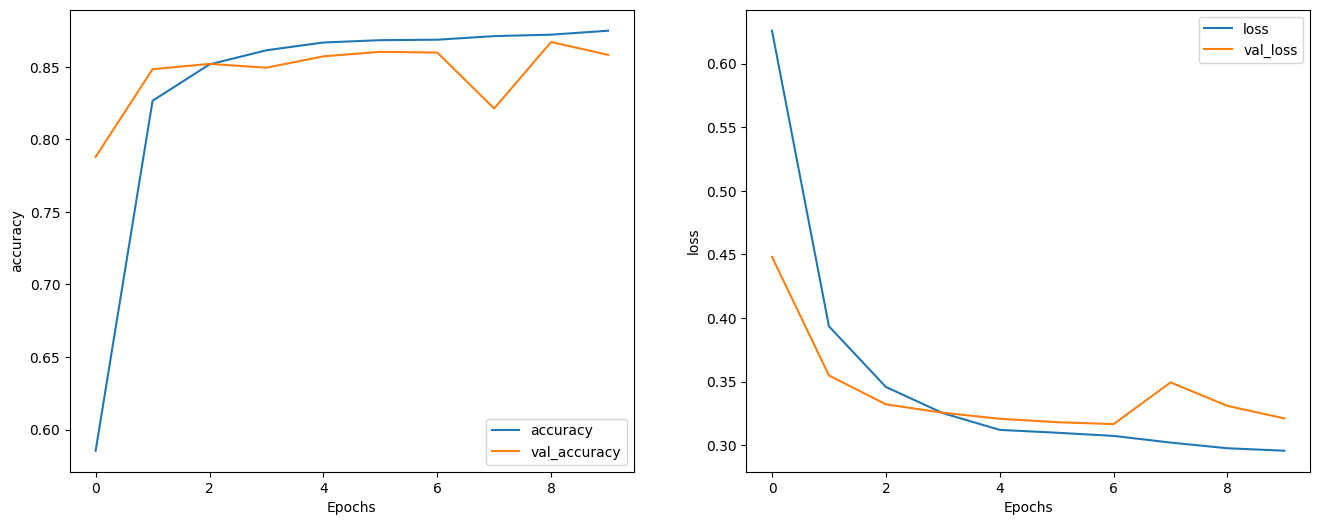

In [ ]:
# visualisasi hasil pelatihan
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')